# Peter and the Wolf: Reinforcement Learning Primer

In this tutorial, we will learn how to apply Reinforcement learning to a problem of path finding. The setting is inspired by [Peter and the Wolf](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) musical fairy tale by Russian composer [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). It is a story about young pioneer Peter, who bravely goes out of his house to the forest clearing to chase a wolf. We will train machine learning algorithms that will help Peter to explore the surrounding area and build an optimal navigation map.

First, let's import a bunch of useful libraries:

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import rlboard
from importlib import reload
reload(rlboard)

<module 'rlboard' from 'c:\\CSS350\\Module-9\\rlboard.py'>

## New World Rules

In this modified version of the game, Peter's survival is more challenging. The new rules are as follows:

* **Energy and Fatigue:** Moving from one place to another costs Peter 1 unit of energy and adds 1 unit of fatigue.
* **Gaining Energy:** Peter can eat apples to gain 10 units of energy.
* **Reducing Fatigue:** Peter can rest under a tree to reduce fatigue by 2 units.
* **Objective:** Peter's main goal is to find and kill the wolf.
* **Winning Condition:** To kill the wolf, Peter must have at least 5 units of energy and his fatigue level must be 5 or less. If he fails, he loses the battle.

Let's now create a random board and see how it looks:

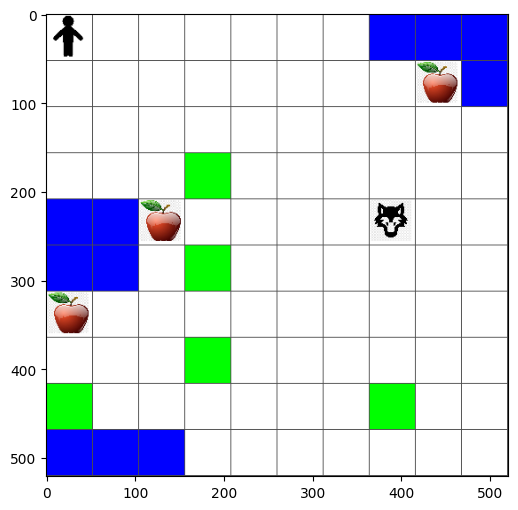

In [11]:
actions = { "U":(-1,0), "D":(1,0), "L":(0,-1), "R":(0,1) }
m = rlboard.Board(10,10)
m.randomize(seed=1)
m.plot()

## Actions and Policy

Peter's goal is to kill the wolf, which requires managing his energy and fatigue. The actions remain the same, but the policy will be more complex.

### Random Walk
First, let's define a random walk policy as a baseline.

In [12]:
def random_policy(brd):
    return random.choice(list(actions.values()))

Let's run the random walk experiment to see how it performs under the new rules.

In [13]:
def run_game(policy, n_games=1000):
    wins = 0
    for _ in range(n_games):
        m.randomize(seed=random.randint(0,10000))
        res = m.walk(policy)
        if res == 1:
            wins += 1
    return wins / n_games

win_rate_random = run_game(random_policy)
print(f"Random walk win rate: {win_rate_random:.2%}")

Random walk win rate: 2.80%


## Reward Function and State Representation

To learn a better policy, we need a reward function and a way to represent the state.
The state now includes energy and fatigue. To handle this, we'll discretize these values into levels.


In [14]:
energy_levels = 5
fatigue_levels = 3

def get_state(b):
    x, y, energy, fatigue = b.state()
    energy_level = min(energy // 5, energy_levels - 1)
    fatigue_level = min(fatigue // 4, fatigue_levels - 1)
    return x, y, energy_level, fatigue_level

def reward_fun(b_old, b_new):
    if b_new.at() == rlboard.Board.Cell.wolf:
        return 1.0 if b_new.energy >= 5 and b_new.fatigue <= 5 else -1.0
    if b_new.at() == rlboard.Board.Cell.water:
        return -1.0
    if b_new.energy > b_old.energy:
        return 0.5 # Ate an apple
    if b_new.fatigue < b_old.fatigue:
        return 0.2 # Rested
    return -0.05 # Step penalty

## Q-Learning

Now, we'll build a Q-table and implement the Q-learning algorithm to find an optimal policy.

In [15]:
Q = np.zeros((m.width, m.height, energy_levels, fatigue_levels, len(actions)))
alpha = 0.2
gamma = 0.9

### Learning Algorithm
Now we are ready to implement the learning algorithm.

In [16]:
def policy(b, Q, eps=0.1):
    if random.random() < eps:
        return random.choice(list(actions.values()))
    else:
        st = get_state(b)
        act_idx = np.argmax(Q[st])
        return list(actions.values())[act_idx]

epochs = 20000
from IPython.display import clear_output
import copy

for i in range(epochs):
    m.randomize(seed=random.randint(0,10000))
    m.random_start()
    
    for _ in range(100): # Limit steps per episode
        s = get_state(m)
        a_val = policy(m, Q)
        a_idx = list(actions.values()).index(a_val)
        
        m_old = copy.deepcopy(m)
        m.move(a_val)
        
        r = reward_fun(m_old, m)
        s_new = get_state(m)
        
        Q[s][a_idx] = (1-alpha)*Q[s][a_idx] + alpha*(r + gamma * np.max(Q[s_new]))
        
        if m.at() in [rlboard.Board.Cell.wolf, rlboard.Board.Cell.water]:
            break
    
    if (i+1) % 1000 == 0:
        clear_output(wait=True)
        print(f"Epoch {i+1}/{epochs}")

Epoch 20000/20000


### Checking the Policy
Let's see how the learned policy performs.

In [17]:
def learned_policy(b):
    return policy(b, Q, eps=0) # Epsilon = 0 for pure exploitation

win_rate_q_learning = run_game(learned_policy)
print(f"Q-learning win rate: {win_rate_q_learning:.2%}")
print(f"Random walk win rate: {win_rate_random:.2%}")

Q-learning win rate: 100.00%
Random walk win rate: 2.80%


### Visualizing the Learned Policy

Now let's visualize the learned policy. We will plot the policy for a state with high energy and low fatigue.

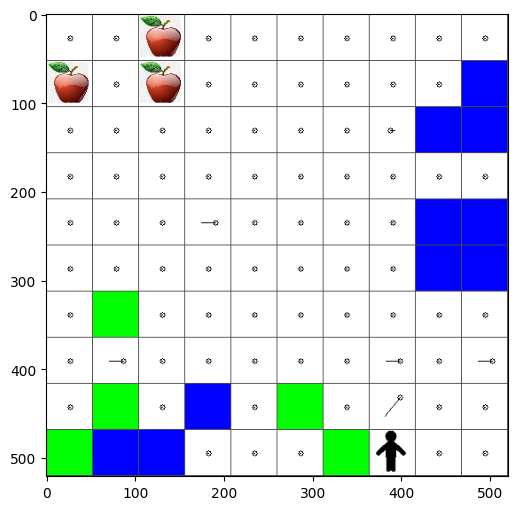

In [18]:
m.plot(Q, energy_level=4, fatigue_level=0)

## Conclusion

In this assignment, we have extended the Peter and the Wolf problem to a more realistic scenario with energy and fatigue. We have seen that Q-learning can significantly outperform a random walk strategy in this more complex environment. By carefully designing the state representation and reward function, we can guide the agent to learn a sophisticated policy that balances exploration and exploitation to achieve its goal.